In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
# import sys
import os


args = 1
os.environ['CUDA_VISIBLE_DEVICES'] = f'{args}'
print(f'Selected GPU {args}')

import jax
import jax.random as jrnd
import jax.numpy as jnp
import distrax as dx
import jaxkern as jk

from jax.config import config
config.update("jax_enable_x64", True)  # crucial for Gaussian processes

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

Selected GPU 1


In [3]:
import sys
sys.path.append('/home/davcic/CP_Testing')
from New_kernel_1 import Discontinuous_multiple

In [4]:
import sys
sys.path.append('/home/davcic/CP_Testing')

from New_kernel_1 import Discontinuous_multiple
from New_kernel_1 import Discontinuous_multiple_params
from New_kernel_1 import Discontinuous_multiple_params_hyper
from Poisson_Process_added import Poisson_Process_hyper
from fullgp import FullMarginalGPModelhyper_mult
from Uniform_modified import Uniform_mod
from Normal_modified import LogNormal_mod
from fullgp import FullLatentGPModelhyper_mult

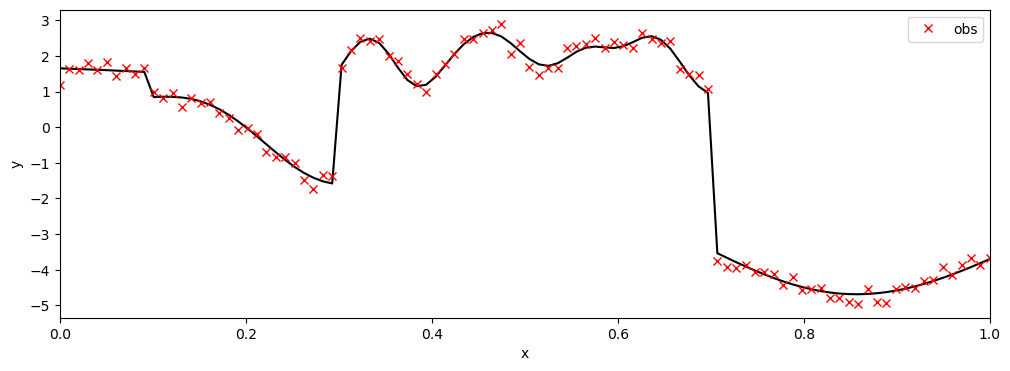

In [5]:
key = jrnd.PRNGKey(12345)

lengthscale_ = jnp.array([0.5, 0.1, 0.04, 0.2])
output_scale_ = jnp.array([3, 2, 1, 5])
obs_noise_ = 0.2
n = 100
x = jnp.linspace(0, 1, n)[:, jnp.newaxis]
x0 = jnp.array([0.3, 0.1, 0.7])
# x0 = jnp.concatenate((jnp.array([0]), x0, jnp.array([x.shape[0]])))
#x0 = jnp.append(jnp.zeros(1), x0, jnp.array(x.shape[0]))
base_kernel = jk.RBF()
kernel = Discontinuous_multiple_params(base_kernel, x0)
K = kernel.cross_covariance(params=dict(lengthscale=lengthscale_,
                                        variance=output_scale_,
                                        num=x0),
                            x=x, y=x)+ 1e-6*jnp.eye(n)

L = jnp.linalg.cholesky(K)
z = jrnd.normal(key, shape=(n,))

f_true = jnp.dot(L, z) + jnp.ones_like(z)
key, obs_key = jrnd.split(key)
y = f_true + obs_noise_*jrnd.normal(obs_key, shape=(n,))

ground_truth = dict(f=f_true,
                    kernel = dict(lengthscale=lengthscale_,
                                    variance=output_scale_,
                                    num = x0),
                    obs_noise=obs_noise_,
                    )

plt.figure(figsize=(12, 4))
plt.plot(x, f_true, 'k', label=r'')
plt.plot(x, y, 'rx', label='obs')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([0., 1.])
plt.legend();

# jnp.savez("f_true.npz", f_true)
# jnp.savez("y.npz", X=y, doc_range = [0, 100])

In [6]:
size = 10
T = 1
max_CP = size
base_kernel = jk.RBF()
kernel = Discontinuous_multiple_params_hyper(base_kernel)

priors = dict(kernel=dict(lengthscale=LogNormal_mod(0, 2, max_CP+1),
                          variance=LogNormal_mod(0., 1, max_CP+1), 
                          num=Poisson_Process_hyper(size, T)
                                                              ),
              likelihood=dict(obs_noise=dx.Transformed(dx.Normal(loc=0.,
                                                                 scale=1.),
                                                       tfb.Exp())),
            #   diag = dict(scale = LogNormal_mod(0, 1, 1)),
              hyper = dict(hyper_pp = dx.Transformed(dx.Normal(loc=0.,
                                                               scale=1.),
                                                     tfb.Exp())))

gp_latent = FullLatentGPModelhyper_mult(x, y, cov_fn=kernel, priors=priors)  # Implies likelihood=Gaussian()

## Doing separate gibbs updating based on the temperature

In [7]:
sys.path.append('/home/davcic/CP_Testing/Classes')

from GP_CP import GP_CP_Marginal, GP_CP_Latent
num_particles = 1000
num_mcmc_steps = 1000
GP_latent = GP_CP_Latent(x, y, cov_fn=kernel, priors=priors, num_particles=num_particles, num_mcmc_steps=num_mcmc_steps)

In [8]:
GP_latent.model_GP(key)

Running Latent GP


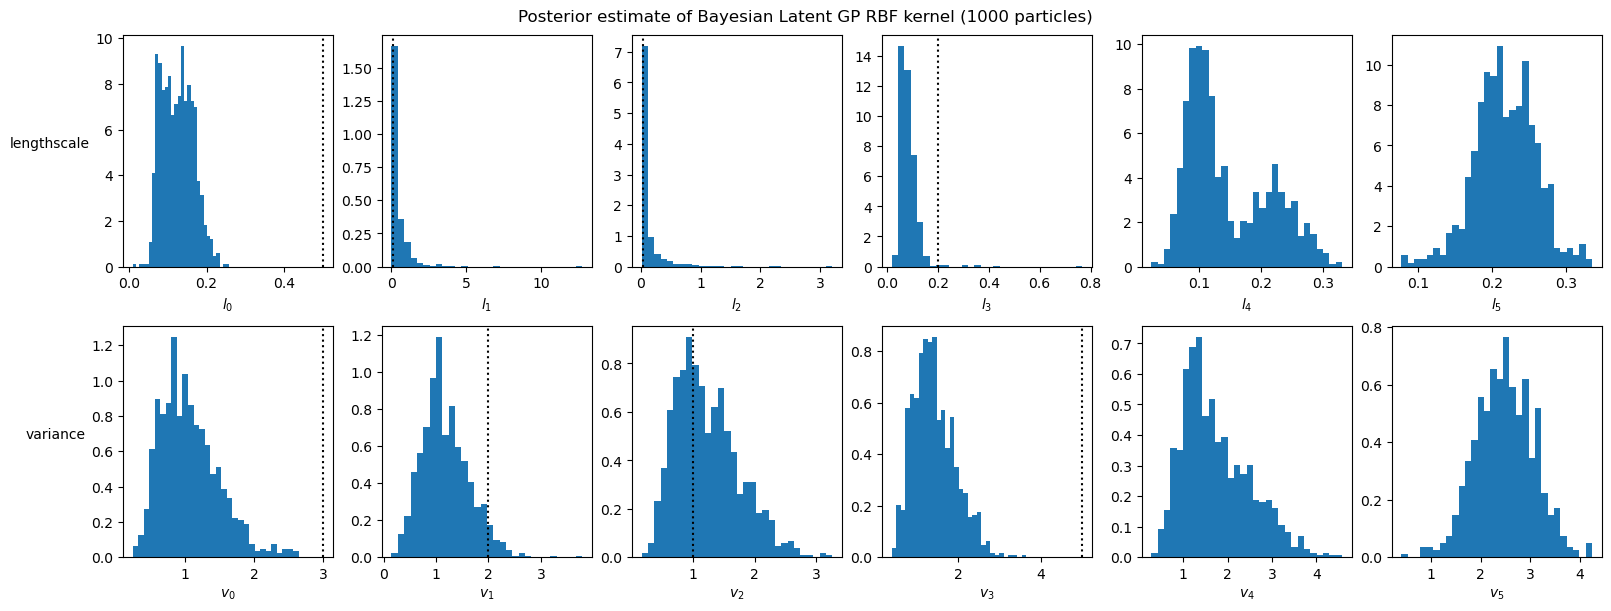

In [9]:
GP_latent.plot_post(ground_truth)

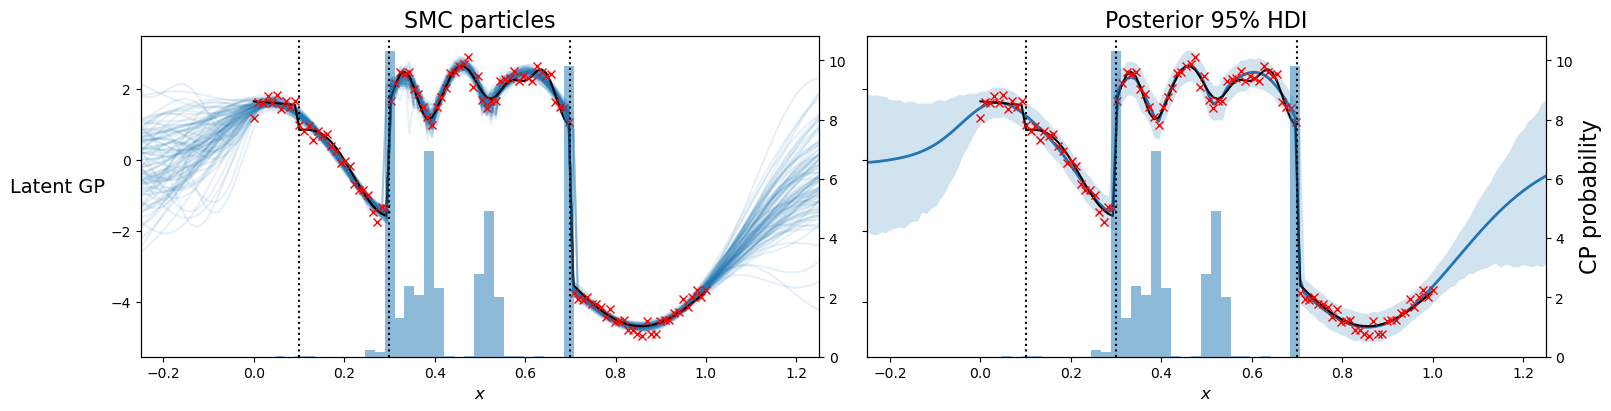

In [10]:
GP_latent.plot_fit(key, True, f_true, ground_truth)

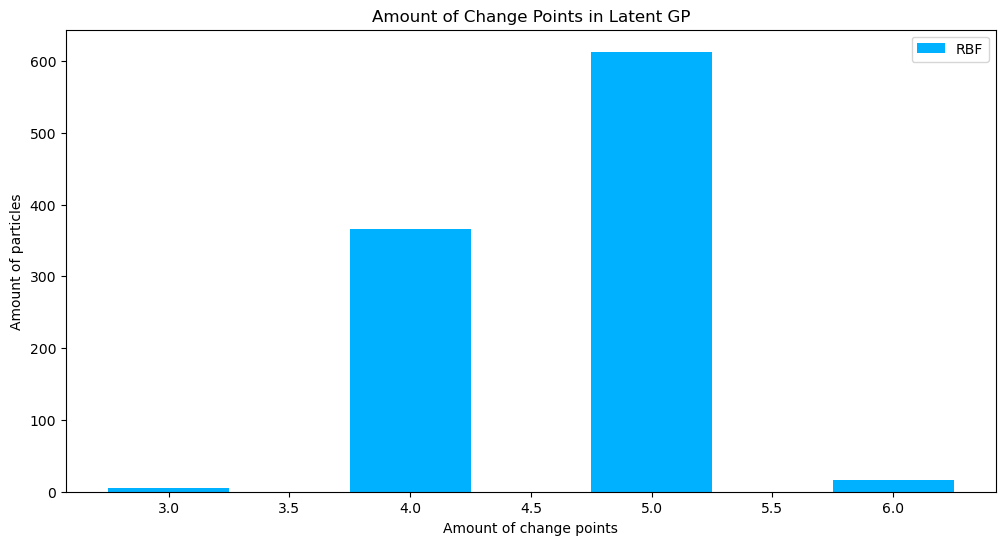

In [11]:
GP_latent.plot_num()

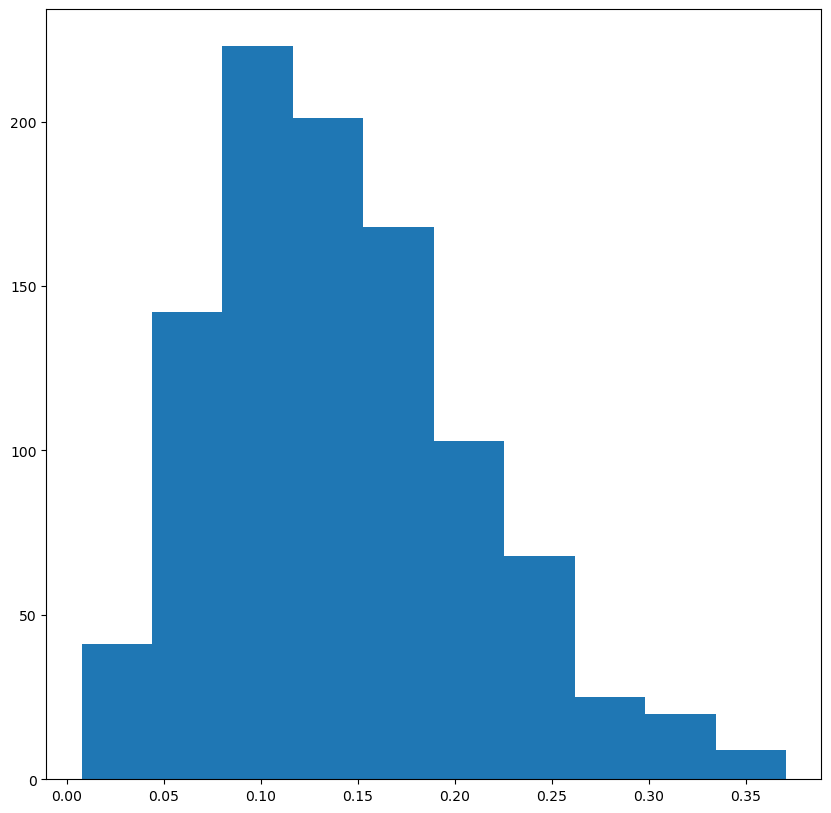

In [20]:
# fig = plt.figure(figsize = (10, 10))
# plt.hist(GP_latent.particles.particles['diag']['scale'].squeeze())
# plt.show()

### Notes on what is happening here:
So, at the beginning we are adding around ~0.1 to the diagonal. This value likely enables us to update around 10-20 parameters at the same time. Therefore, it is able to settle for abour 3-5 change points. While the temperature decreases, it is able to update the parameters less and less. therefore it stays at 3-5 CPs (since if it added new CPs it would not be able to update them). Once a threshold is reached, we start to Gibbs sample for each dimension. \
Now, it can start optimizing to maximize the likelihood of $f$ given $y$, which can be done easiest in this case by improving the particles with more CPs, since more CPs enable a better fit of $f$ given $y$. However, I believe it does not add more CPs anymore since it is 'too late' within the SMC algorithm to learn completely new locations and covariance parameters, so new change points with new parameters will likely no longer be propagated compared to the alomst optimized particles with 3-5 CPs. The temperature at which the individula Gibbs sampling starts is about at 0.6, so quite late. \
If we use the individual dimension gibbs sampling from the beginning, it will immediately start to go to the maximum amount of CPs since that will optimize $f$ given $y$.

## Normal Gibbs updating

In [17]:
sys.path.append('/home/davcic/CP_Testing/Classes')

from GP_CP import GP_CP_Marginal, GP_CP_Latent
num_particles = 1000
num_mcmc_steps = 1000
GP_latent_old = GP_CP_Latent(x, y, cov_fn=kernel, priors=priors, num_particles=num_particles, num_mcmc_steps=num_mcmc_steps)

In [18]:
# key, subkey = jrnd.split(key)
GP_latent_old.model_GP(key)

Running Latent GP


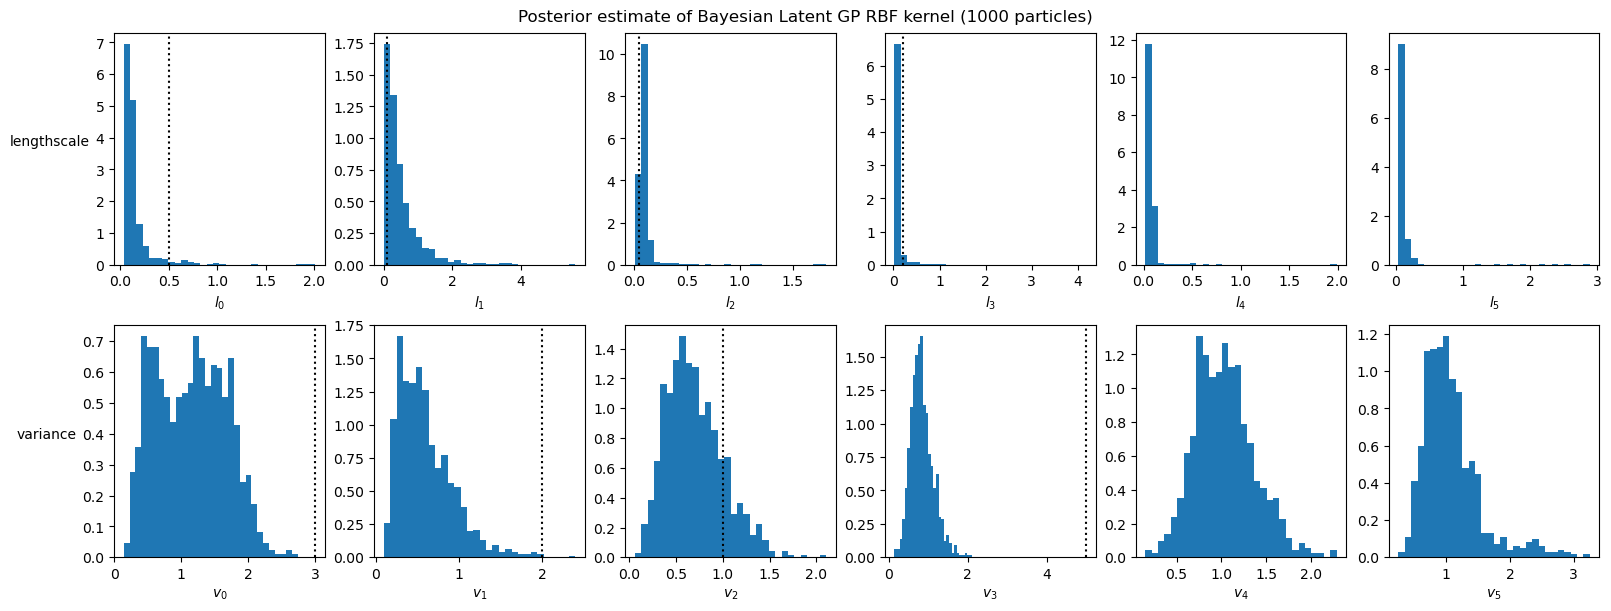

In [22]:
GP_latent_old.plot_post(ground_truth)

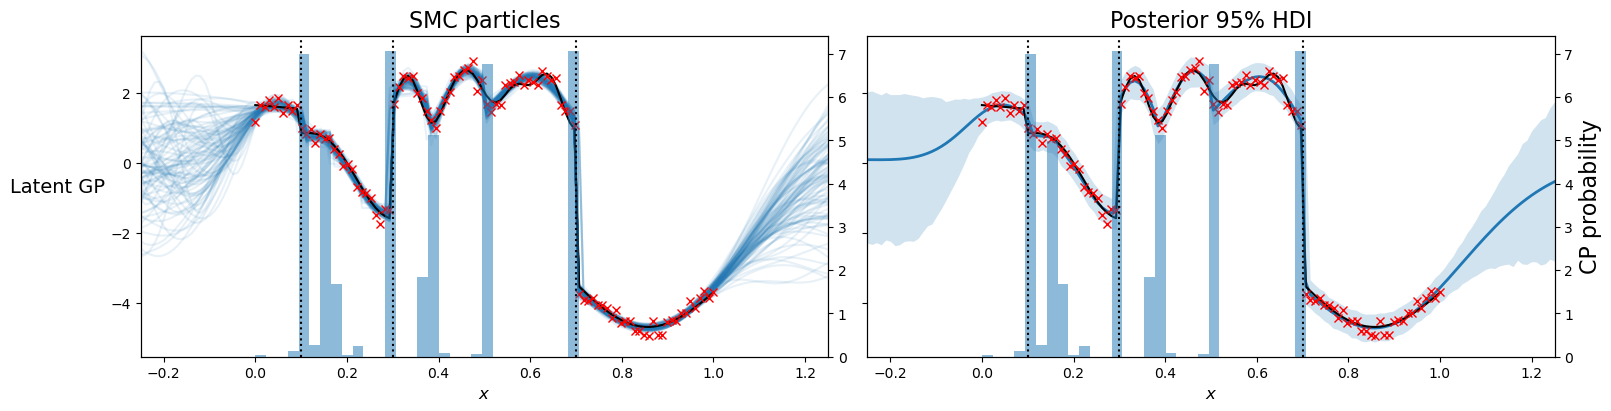

In [23]:
GP_latent_old.plot_fit(key, True, f_true, ground_truth)

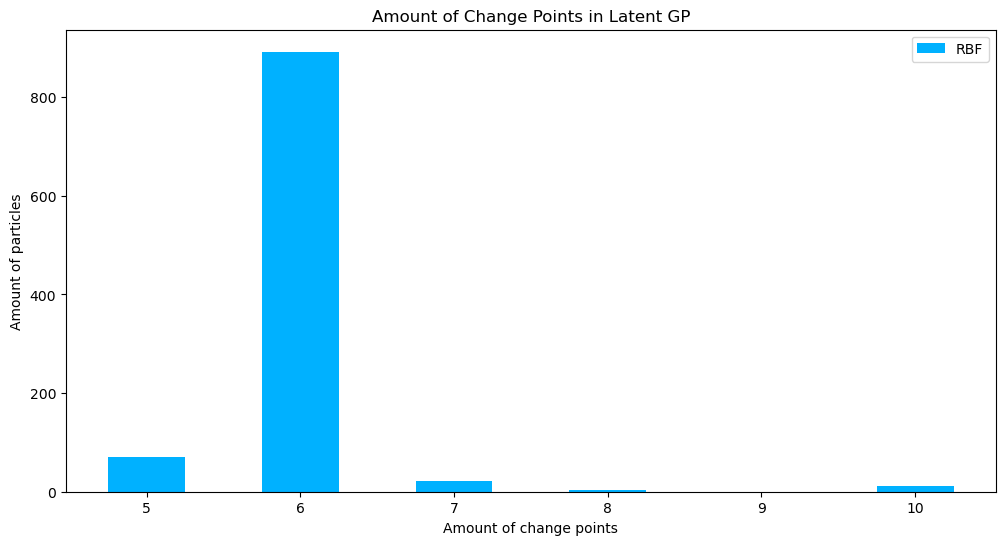

In [21]:
GP_latent_old.plot_num()